### Cleaning data

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kartik2112/fraud-detection")

print("Path to dataset files:", path)

100%|██████████| 202M/202M [01:21<00:00, 2.59MB/s] 

Extracting files...


Path to dataset files: C:\Users\Republic Of Computer\.cache\kagglehub\datasets\kartik2112\fraud-detection\versions\1


In [5]:
import os
import pandas as pd

# Affiche tous les fichiers dans le dossier téléchargé
print("Contenu du dossier :", os.listdir(path))


Contenu du dossier : ['fraudTest.csv', 'fraudTrain.csv']


In [6]:
# Charger les données d'entraînement
train_df = pd.read_csv(os.path.join(path, 'fraudTrain.csv'))

# Charger les données de test
test_df = pd.read_csv(os.path.join(path, 'fraudTest.csv'))

# Affichage des premières lignes
print("Train set:")
print(train_df.head())

print("\nTest set:")
print(test_df.head())

Train set:
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      lat      long  \
0    Banks      F                561 Perry Cove  ...  36.0788  -81.1781   
1     Gill      F  43039 Riley Greens Suite 3

In [7]:
# length of each dataset
print("Train set length:", len(train_df))
print("Test set length:", len(test_df))

Train set length: 1296675
Test set length: 555719


In [8]:
# missing values
print("Train set missing values:")
print(train_df.isnull().sum())

print("\nTest set missing values:")
print(test_df.isnull().sum())

Train set missing values:
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

Test set missing values:
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state            

In [9]:
# From the test how many observation is_fraud=1
test_df[test_df['is_fraud'] == 1].shape

(2145, 23)

In [10]:
# Vérifions la répartition de la variable cible
print(train_df['is_fraud'].value_counts(normalize=True))
print(train_df['is_fraud'].value_counts())


is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64
is_fraud
0    1289169
1       7506
Name: count, dtype: int64


##### Nous sommes donc en presence de donnees desequilibres




In [25]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

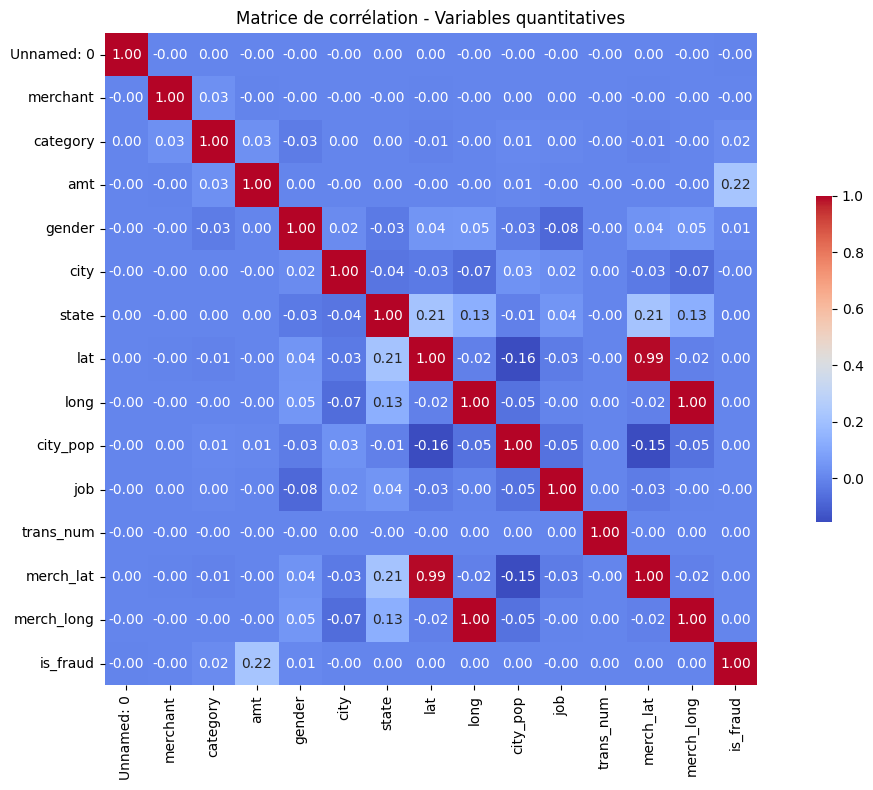

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Repartons du dataframe propre
df = train_df.copy()
cols_to_drop = ['trans_date_trans_time', 'cc_num', 'first', 'last', 'street', 'zip', 'unix_time', 'dob']
df.drop(columns=cols_to_drop, inplace=True)

# Encodage des colonnes catégorielles (nécessaire si certaines sont object mais numériques)
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Sélection des variables quantitatives uniquement
quant_df = df.select_dtypes(include=['int64', 'float64'])

# Matrice de corrélation
corr = quant_df.corr()

# Affichage heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'shrink': .5})
plt.title("Matrice de corrélation - Variables quantitatives")
plt.tight_layout()
plt.show()


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Nettoyage et préparation
df = train_df.copy()
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_date_trans_time'].dt.hour
df['weekday'] = df['trans_date_trans_time'].dt.day_name()
df['age'] = pd.to_datetime('2025-01-01').year - pd.to_datetime(df['dob']).dt.year  # approx

# Encodage des catégorielles simples si besoin
df['gender'] = df['gender'].fillna('Unknown')


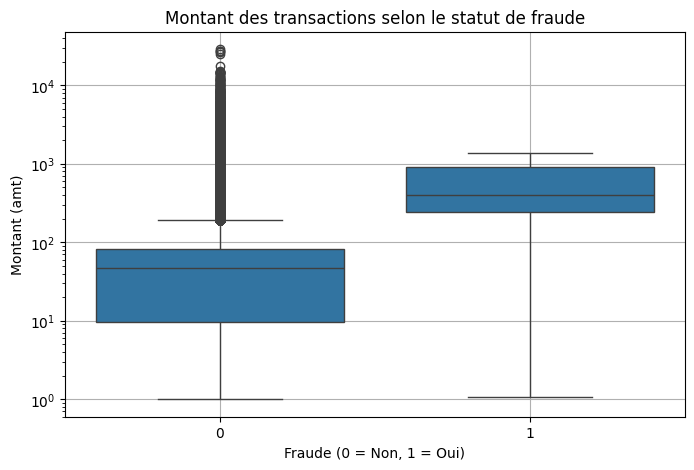

In [45]:
plt.figure(figsize=(8,5))
sns.boxplot(x='is_fraud', y='amt', data=df)
plt.title("Montant des transactions selon le statut de fraude")
plt.xlabel("Fraude (0 = Non, 1 = Oui)")
plt.ylabel("Montant (amt)")
plt.yscale('log')  # car la distribution est souvent très asymétrique
plt.grid(True)
plt.show()


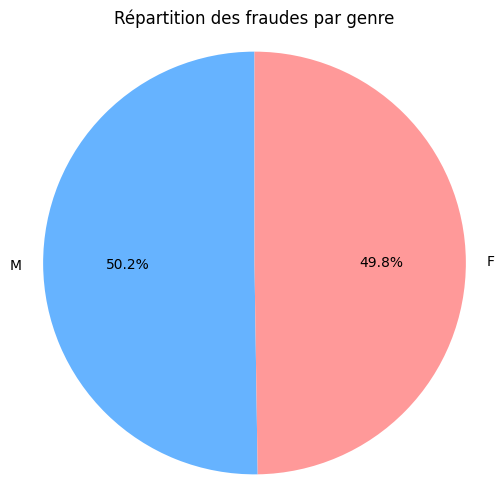

In [47]:
# Filtrer uniquement les transactions frauduleuses
fraud_by_gender = df[df['is_fraud'] == 1]['gender'].value_counts()

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(fraud_by_gender, labels=fraud_by_gender.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title("Répartition des fraudes par genre")
plt.axis('equal')  # cercle parfait
plt.show()


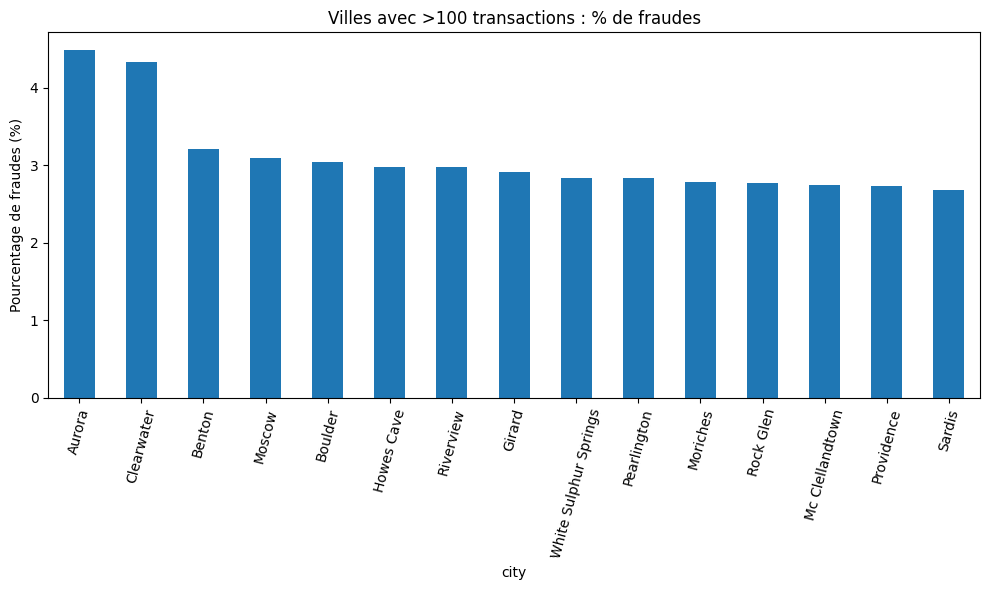

In [49]:
city_counts = df['city'].value_counts()
valid_cities = city_counts[city_counts > 100].index
df_city = df[df['city'].isin(valid_cities)]

city_fraud_rate = df_city.groupby('city')['is_fraud'].mean().sort_values(ascending=False) * 100

plt.figure(figsize=(10,6))
city_fraud_rate.head(15).plot(kind='bar')
plt.ylabel("Pourcentage de fraudes (%)")
plt.title("Villes avec >100 transactions : % de fraudes")
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()


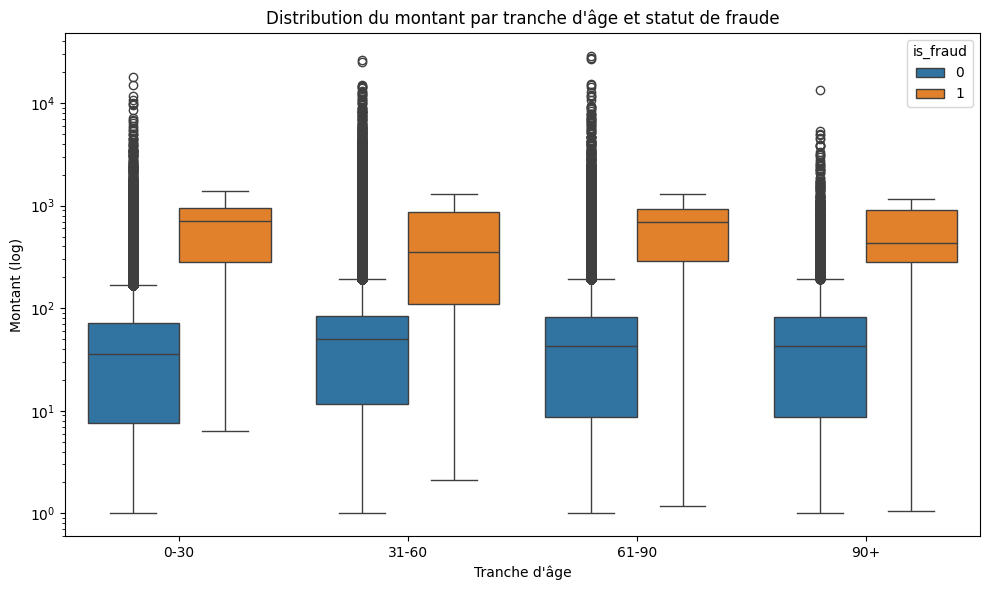

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='age_group', y='age', hue='is_fraud', data=df)
plt.yscale('log')
plt.title("Distribution du montant par tranche d'âge et statut de fraude")
plt.xlabel("Tranche d'âge")
plt.ylabel("Montant (log)")
plt.tight_layout()
plt.show()


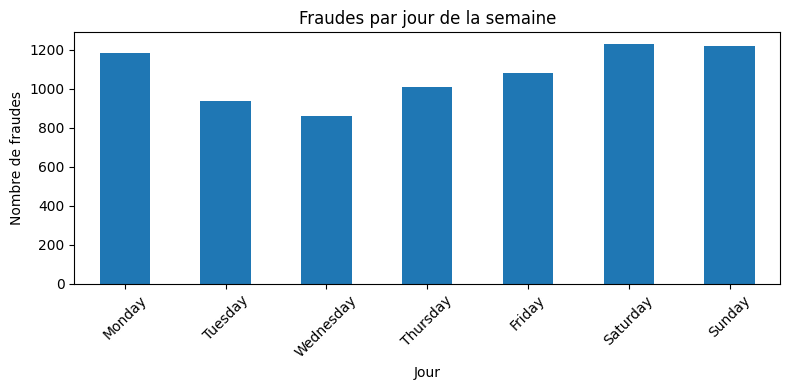

In [56]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['weekday'] = df['trans_date_trans_time'].dt.day_name()

fraud_by_weekday = df[df['is_fraud'] == 1]['weekday'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(8,4))
fraud_by_weekday.plot(kind='bar')
plt.title("Fraudes par jour de la semaine")
plt.xlabel("Jour")
plt.ylabel("Nombre de fraudes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


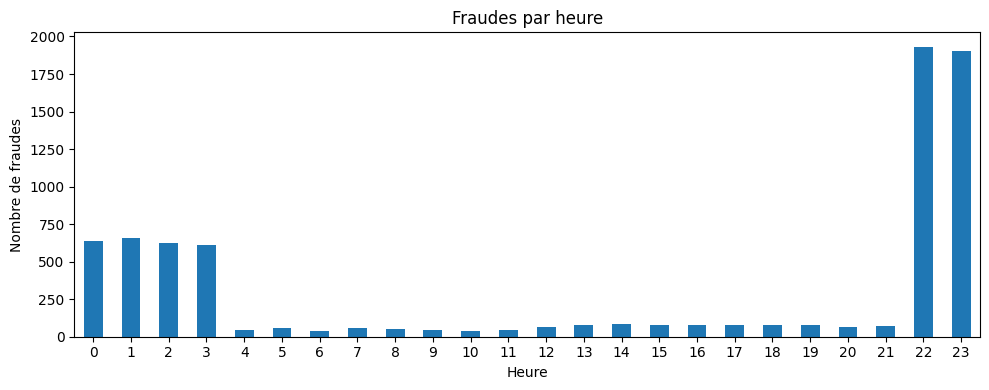

In [57]:
df['hour'] = df['trans_date_trans_time'].dt.hour
fraud_by_hour = df[df['is_fraud'] == 1]['hour'].value_counts().sort_index()

plt.figure(figsize=(10,4))
fraud_by_hour.plot(kind='bar')
plt.title("Fraudes par heure")
plt.xlabel("Heure")
plt.ylabel("Nombre de fraudes")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [35]:
# === 1. Préparation des données ======================================
def preprocess_data(df):
    # Supprimer colonnes inutiles ou à forte cardinalité
    cols_to_drop = ['trans_date_trans_time', 'cc_num', 'first', 'last', 'street', 'zip', 'unix_time', 'dob','long','lat']
    df = df.drop(columns=cols_to_drop)

    # Encoder les colonnes catégorielles
    for col in df.select_dtypes(include='object').columns:
        df[col] = LabelEncoder().fit_transform(df[col])

    X = df.drop(columns=['is_fraud'])
    y = df['is_fraud']
    return X, y

##### Train undersampling

In [70]:
def resample_train_only(train_df):
    # Préparation
    df = train_df.copy()
    cols_to_drop = ['trans_date_trans_time', 'cc_num', 'first', 'last', 'street', 'zip', 'unix_time', 'dob']
    df.drop(columns=cols_to_drop, inplace=True)

    for col in df.select_dtypes(include='object').columns:
        df[col] = LabelEncoder().fit_transform(df[col])

    X_train = df.drop(columns=['is_fraud'])
    y_train = df['is_fraud']

    # Under-sampling uniquement sur l'entraînement
    rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

    return X_train_res, y_train_res


###### Test undersampling

In [69]:
def prepare_test(test_df):
    df = test_df.copy()
    cols_to_drop = ['trans_date_trans_time', 'cc_num', 'first', 'last', 'street', 'zip', 'unix_time', 'dob']
    df.drop(columns=cols_to_drop, inplace=True)

    for col in df.select_dtypes(include='object').columns:
        df[col] = LabelEncoder().fit_transform(df[col])

    X_test = df.drop(columns=['is_fraud'])
    y_test = df['is_fraud']
    return X_test, y_test


In [71]:
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np

def train_and_evaluate(model, name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Gestion des probabilités selon le type de modèle
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
        # Normaliser les scores entre 0 et 1
        y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())
    else:
        y_proba = np.zeros_like(y_pred)  # placeholder si aucune proba

    # Évaluation
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    
    try:
        auc = roc_auc_score(y_test, y_proba)
        print(f"AUC: {auc:.4f}")
        RocCurveDisplay.from_predictions(y_test, y_proba, name=name)
    except:
        print("Impossible de calculer l'AUC (probabilités manquantes)")
    
    plt.title(f"ROC - {name}")
    plt.grid(True)
    plt.show()



=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    553574
           1       0.09      0.91      0.17      2145

    accuracy                           0.97    555719
   macro avg       0.55      0.94      0.58    555719
weighted avg       1.00      0.97      0.98    555719

AUC: 0.9877


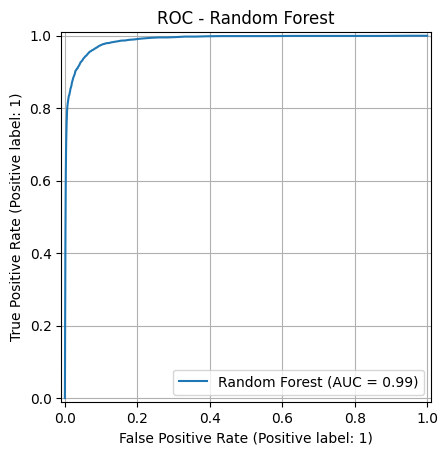

c:\Users\Republic Of Computer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:36:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    553574
           1       0.08      0.95      0.14      2145

    accuracy                           0.96    555719
   macro avg       0.54      0.95      0.56    555719
weighted avg       1.00      0.96      0.97    555719

AUC: 0.9925


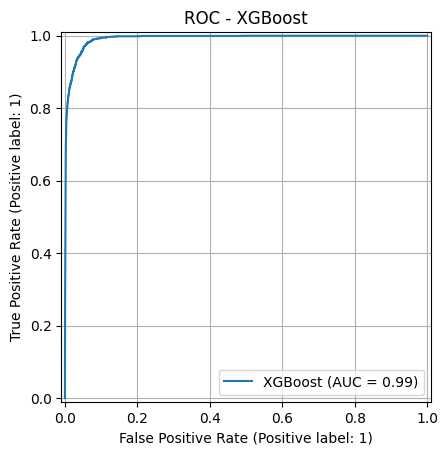


=== Decision Tree ===
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    553574
           1       0.06      0.92      0.10      2145

    accuracy                           0.94    555719
   macro avg       0.53      0.93      0.54    555719
weighted avg       1.00      0.94      0.97    555719

AUC: 0.9778


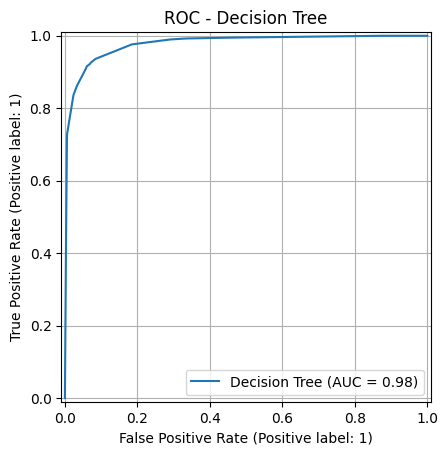

In [38]:
# === 4. Application corrigée ==============================================

# Prétraitement sur train + under-sampling
train_clean = train_df.copy()
X_train_full, y_train_full = preprocess_data(train_clean)

rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_train, y_train = rus.fit_resample(X_train_full, y_train_full)

# Prétraitement sur test (pas d'under-sampling)
test_clean = test_df.copy()
X_test, y_test = preprocess_data(test_clean)

# Modèles
model_rf = RandomForestClassifier(random_state=42)
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_dt = DecisionTreeClassifier(max_depth=5, random_state=42)

# Entraînement + AUC/ROC
train_and_evaluate(model_rf, "Random Forest", X_train, y_train, X_test, y_test)
train_and_evaluate(model_xgb, "XGBoost", X_train, y_train, X_test, y_test)
train_and_evaluate(model_dt, "Decision Tree", X_train, y_train, X_test, y_test)


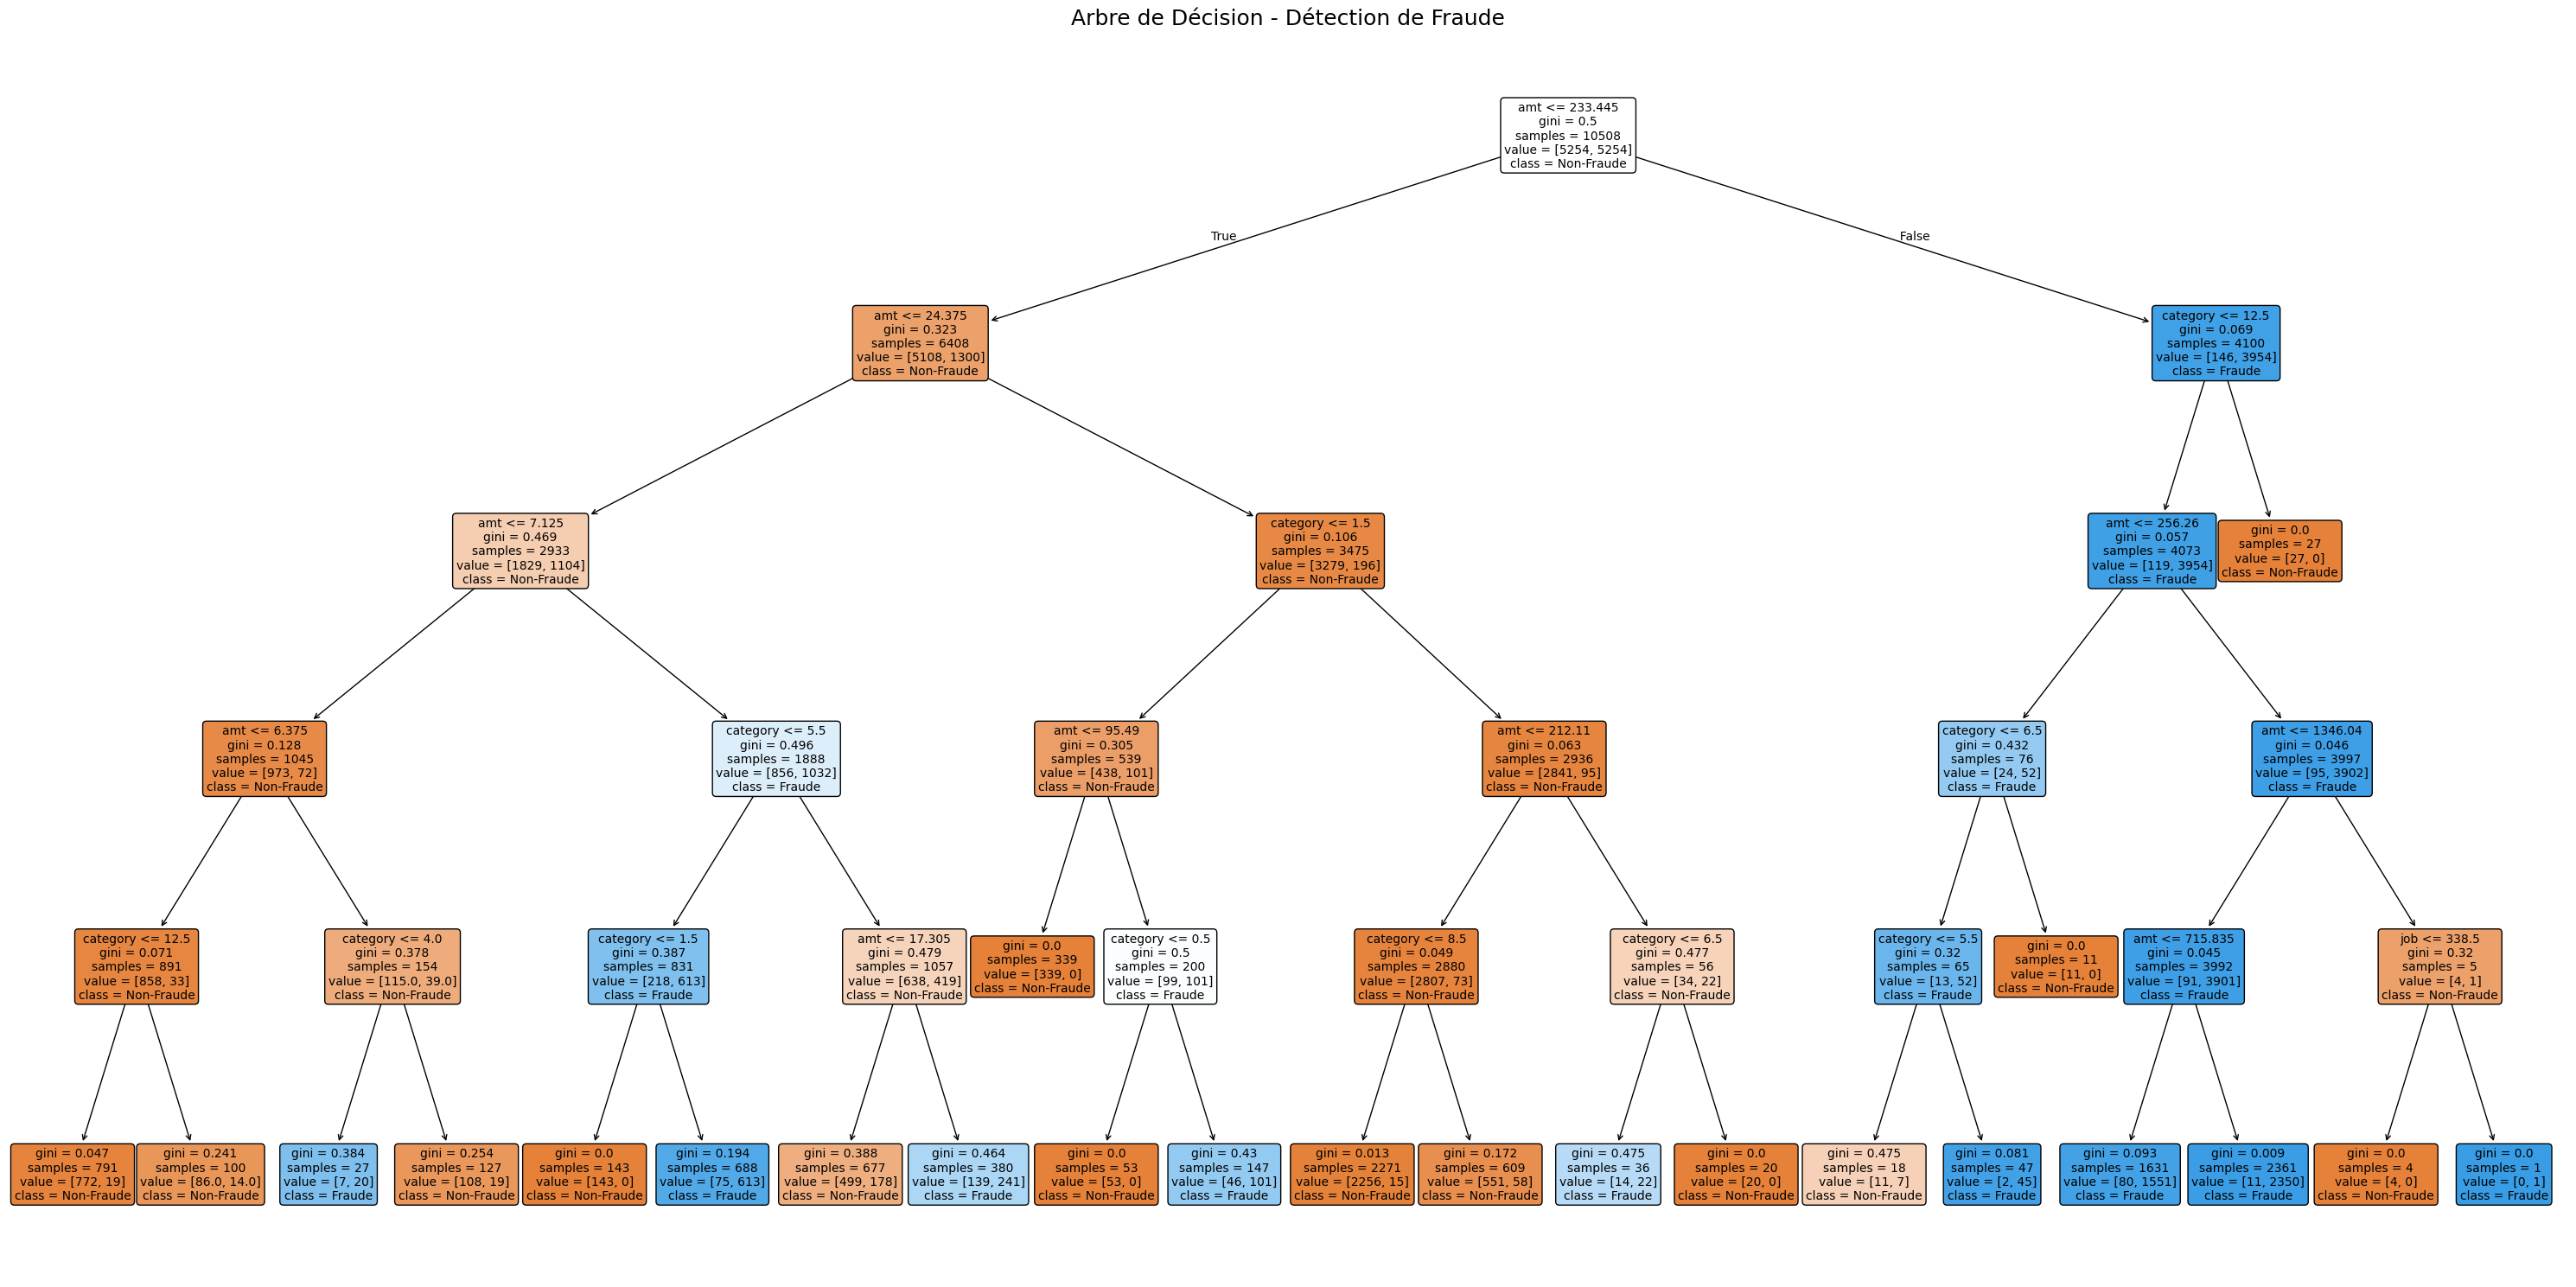

In [68]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Adapter la taille de la figure à la taille de l'arbre
plt.figure(figsize=(30, 15))  # largeur x hauteur

plot_tree(model_dt,
          feature_names=X.columns,
          class_names=["Non-Fraude", "Fraude"],
          filled=True,
          rounded=True,
          fontsize=10)  # réduis la taille si trop chargé

plt.title("Arbre de Décision - Détection de Fraude", fontsize=18)
plt.tight_layout()
plt.show()


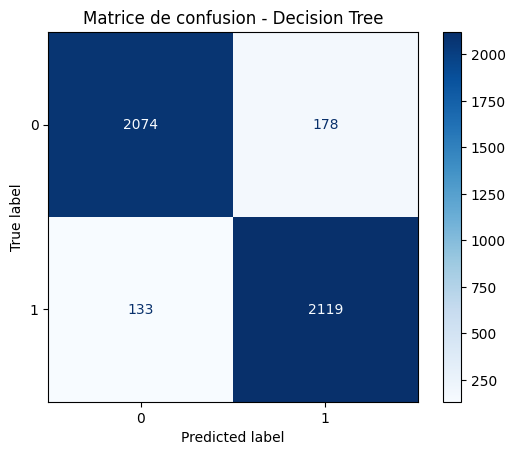

In [40]:
# === 6. Matrice de confusion pour Decision Tree =======================
cm = confusion_matrix(y_test, model_dt.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_dt.classes_)
disp.plot(cmap="Blues")
plt.title("Matrice de confusion - Decision Tree")
plt.show()


=== SVM (RBF) ===
              precision    recall  f1-score   support

           0       0.53      0.55      0.54      2252
           1       0.53      0.51      0.52      2252

    accuracy                           0.53      4504
   macro avg       0.53      0.53      0.53      4504
weighted avg       0.53      0.53      0.53      4504

AUC: 0.5374

=== Réseau de Neurones (MLP) ===
              precision    recall  f1-score   support

           0       0.77      0.35      0.48      2252
           1       0.58      0.90      0.70      2252

    accuracy                           0.62      4504
   macro avg       0.68      0.62      0.59      4504
weighted avg       0.68      0.62      0.59      4504

AUC: 0.6396


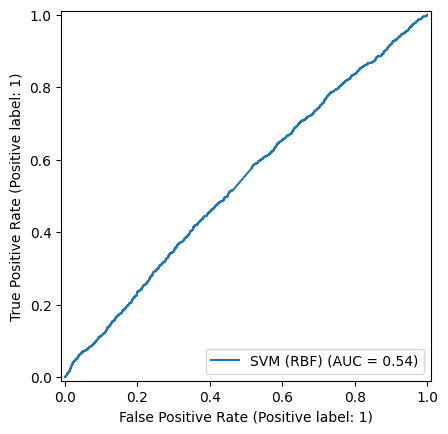

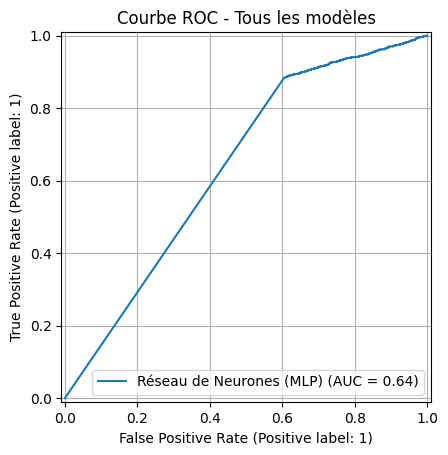

In [41]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# === 7. SVM ========================================================
model_svm = SVC(probability=True, kernel='rbf', random_state=42)
train_and_evaluate(model_svm, "SVM (RBF)")

# === 8. Réseau de neurones (MLP) ===================================
model_mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
train_and_evaluate(model_mlp, "Réseau de Neurones (MLP)")

# === 9. Affichage global ROC =======================================
import matplotlib.pyplot as plt
plt.title("Courbe ROC - Tous les modèles")
plt.grid(True)
plt.show()


=== Réseau de neurones (avec SMOTE) ===


c:\Users\Republic Of Computer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Republic Of Computer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Republic Of Computer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    386751
           1       0.00      0.00      0.00      2252

    accuracy                           0.99    389003
   macro avg       0.50      0.50      0.50    389003
weighted avg       0.99      0.99      0.99    389003

AUC: 0.5000


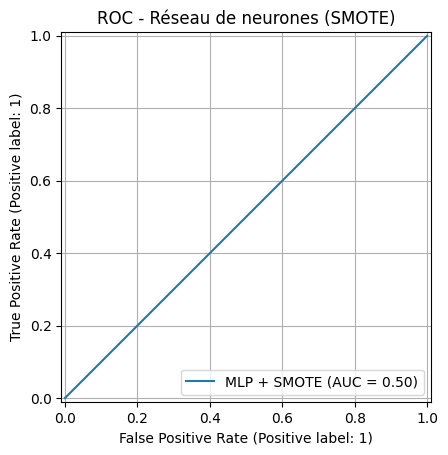

In [33]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE

# === 1. Prétraitement des données ===================================
df = train_df.copy()
cols_to_drop = ['trans_date_trans_time', 'cc_num', 'first', 'last', 'street', 'zip', 'unix_time', 'dob']
df.drop(columns=cols_to_drop, inplace=True)

# Encodage des colonnes catégorielles
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

# === 2. Split avant SMOTE (bonnes pratiques) =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# === 3. SMOTE sur les données d'entraînement =========================
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# === 4. Réseau de neurones ==========================================
model_mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
model_mlp.fit(X_train_res, y_train_res)

# === 5. Évaluation ===================================================
y_pred = model_mlp.predict(X_test)
y_proba = model_mlp.predict_proba(X_test)[:, 1]

print("=== Réseau de neurones (avec SMOTE) ===")
print(classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc:.4f}")

RocCurveDisplay.from_predictions(y_test, y_proba, name="MLP + SMOTE")
plt.title("ROC - Réseau de neurones (SMOTE)")
plt.grid(True)
plt.show()
